In [1]:
import time
from datetime import timedelta
import matplotlib.pyplot as plt
start = time.time()

import numpy as np
import pandas as pd
OUTPUT_DIR = 'out.csv'

#### Data import and treatment

In [2]:
# Data import
_ratings = pd.read_csv('ratings.csv')
_ratings.columns = ['UserId:ItemId', 'Rating', 'Timestamp']
_targets = pd.read_csv('targets.csv')

#### Preparing train/validation sets

In [3]:
# Shuffle data
_ratings = _ratings.sample(frac=1).reset_index(drop=True)

# Separate first column
sep = _ratings['UserId:ItemId'].str.split(':', expand=True)
sep.columns = ['UserId', 'ItemId']
_ratings = pd.concat([_ratings, sep], axis=1)

# Delete columns
_ratings = _ratings.drop(['UserId:ItemId'], axis=1)
del sep

_ratings.head()

,Rating,Timestamp,UserId,ItemId
0,9,1370799567,u0012761,i0100133
1,4,1382958116,u0006729,i1343092
2,9,1414439708,u0015775,i2015381
3,6,1374549172,u0032305,i1811315
4,7,1371504776,u0002369,i0770828


In [4]:
_ratings.shape

(336672, 4)

#### Encoding users/items

In [5]:
def encode_column(column):
    keys = column.unique()
    key_to_id = {key:idx for idx,key in enumerate(keys)}
    return key_to_id, np.array([key_to_id[x] for x in column]), len(keys)

In [6]:
def encode_df(df):
    item_ids, df.loc[:,'ItemId'], num_item = encode_column(df['ItemId'].copy())
    user_ids, df.loc[:,'UserId'], num_users = encode_column(df['UserId'].copy())
    return df, num_users, num_item, user_ids, item_ids

In [7]:
df, num_users, num_item, user_ids, item_ids = encode_df(_ratings)
print("Number of users :", num_users)
print("Number of items :", num_item)
df.head()

Number of users : 34105
Number of items : 19498


,Rating,Timestamp,UserId,ItemId
0,9,1370799567,0,0
1,4,1382958116,1,1
2,9,1414439708,2,2
3,6,1374549172,3,3
4,7,1371504776,4,4


#### Pre-processing

In [8]:
n_users = df["UserId"].unique().shape[0]
n_items = df["ItemId"].unique().shape[0]
n_rating = df["Rating"].unique().shape[0]
print ('%i unique users' %n_users)
print ('%i unique items' %n_items)
print ('%i unique ratings' %n_rating)

34105 unique users
19498 unique items
11 unique ratings


In [9]:
# create a sparse user-item matrix
ratings = df.pivot(index="UserId", columns="ItemId", values="Rating")
ratings = ratings.fillna(0).values

In [10]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('percentage of user-items that have a rating: {:.2f}%'.format(sparsity))

percentage of user-items that have a rating: 0.05%


In [11]:
# This creats a validation dataset by selecting rows (user) that have 35 or more ratings, then randomly select 15 of those ratings
# For validation set, but set those values to 0 in the training set.

def train_test_split(ratings):
    validation = np.zeros(ratings.shape)
    train = ratings.copy() #don't do train=ratings, other wise, ratings becomes empty
    
    for user in np.arange(ratings.shape[0]):
        if len(ratings[user,:].nonzero()[0])>=35:  # 35 seems to be best, it depends on sparsity of your user-item matrix
            val_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=15, #tweak this, 15 seems to be optimal
                                        replace=False)
            train[user, val_ratings] = 0
            validation[user, val_ratings] = ratings[user, val_ratings]
    print(validation.shape)
    return train, validation

In [12]:
train, val = train_test_split(ratings)

(34105, 19498)


#### Training model

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [14]:
lmbda = 0.2 # Regularization parameter
k = 3 # tweak this parameter
n_epochs = 45  # Number of epochs
alpha=0.01  # Learning rate

m, n = train.shape  # Number of users and items
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix

In [15]:
#P is latent user feature matrix
#Q is latent item feature matrix
def prediction(P,Q):
    return np.dot(P.T,Q)

In [16]:
train_errors = []
val_errors = []

#Only consider items with ratings 
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - prediction(P[:,u],Q[:,i])  # Calculate error for gradient update
        P[:,u] += alpha * ( e * Q[:,i] - lmbda * P[:,u]) # Update latent user feature matrix
        Q[:,i] += alpha * ( e * P[:,u] - lmbda * Q[:,i])  # Update latent item feature matrix
    
    train_rmse = rmse(prediction(P,Q),train)
    val_rmse = rmse(prediction(P,Q),val)
    
    if (epoch%5==0): print("(Epoch:", epoch+1, ") Train RMSE:", train_rmse, "- Validation RMSE:", val_rmse)
    elapsed = (time.time()-start)
    print("Time elapsed:",str(timedelta(seconds=elapsed)), "\n")
    
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

(Epoch: 1 ) Train RMSE: 2.00052608665885 - Validation RMSE: 1.8578984979690842
Time elapsed: 0:02:15.548732 

(Epoch: 2 ) Train RMSE: 1.760136369810759 - Validation RMSE: 1.7146296854169616
Time elapsed: 0:03:07.685251 

(Epoch: 3 ) Train RMSE: 1.6451154601572497 - Validation RMSE: 1.6597033575248836
Time elapsed: 0:03:56.915102 

(Epoch: 4 ) Train RMSE: 1.5714509277644764 - Validation RMSE: 1.6266496847948153
Time elapsed: 0:04:40.653653 

(Epoch: 5 ) Train RMSE: 1.5188377611344006 - Validation RMSE: 1.6040373381246715
Time elapsed: 0:05:25.601859 

(Epoch: 6 ) Train RMSE: 1.4789754304803215 - Validation RMSE: 1.5874850697310328
Time elapsed: 0:06:15.035714 

(Epoch: 7 ) Train RMSE: 1.447624108139619 - Validation RMSE: 1.5748361779994167
Time elapsed: 0:07:01.570116 

(Epoch: 8 ) Train RMSE: 1.4223074433130818 - Validation RMSE: 1.5648745003033286
Time elapsed: 0:07:46.384839 



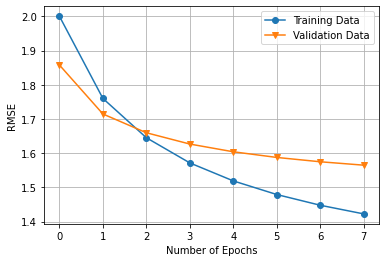

In [17]:
%matplotlib inline

plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), val_errors, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

#### Generating targets output for submission

In [18]:
# recover the matrix of predictions
SGD_predictions = prediction(P,Q)

In [19]:
mean = SGD_predictions.mean()

In [20]:
_predictions = _targets.copy()
_predictions['Prediction'] = 0

In [21]:
# calculate user/item means just if necessary
for i in range(_predictions.shape[0]):
    inf = _predictions['UserId:ItemId'][i].split(':')
    
    if inf[0] not in user_ids:
        if inf[1] not in item_ids:  # if theres no one in data base
            _predictions.loc[i, 'Prediction'] = mean
        else:  # if user not in data base - calculate item means
            _predictions.loc[i, 'Prediction'] = np.mean(SGD_predictions[:][item_ids[inf[1]]])
        
    elif inf[1] not in item_ids:
        if inf[0] not in user_ids:  # if theres no one in data base
            _predictions.loc[i, 'Prediction'] = mean
        else:  # if item not in data base - calculate user means
            _predictions.loc[i, 'Prediction'] = np.mean(SGD_predictions[user_ids[inf[0]]][:])
        
    else:
        _predictions.loc[i, 'Prediction'] = SGD_predictions[user_ids[inf[0]]][item_ids[inf[1]]]

In [22]:
_predictions.head()

,UserId:ItemId,Prediction
0,u0000039:i0060196,7.452875
1,u0000039:i0099077,7.372763
2,u0000039:i0102926,7.574526
3,u0000039:i0109830,7.660983
4,u0000039:i0113277,7.089986


In [23]:
_predictions.shape

(77276, 2)

In [24]:
_predictions.to_csv(OUTPUT_DIR, index=False)

In [25]:
elapsed = (time.time()-start)
print("Time elapsed:",str(timedelta(seconds=elapsed)), "\n")

Time elapsed: 0:08:17.633186 

